# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# !conda install -c conda-forge spacy --y
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
# import libraries
from datetime import datetime
import joblib
import re
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# load data from database
engine = create_engine('sqlite:///messages.db')
df = pd.read_sql('SELECT * FROM messages', engine)
X = df['message'].copy()
Y = df.iloc[:, 4:].copy()
X.head()

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

In [5]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def load_data(database_filepath):
    engine = create_engine('sqlite:///' + database_filepath)
    df = pd.read_sql('SELECT * FROM messages', engine)
    X = df['message'].copy()
    Y = df.iloc[:, 4:].copy()
    categories = Y.columns.tolist()
    return X, Y, categories


C = Y.columns.tolist()
x, y, c = load_data('messages.db')

print(X.equals(x))
print(Y.equals(y))
print(sum(C[i] == c[i] for i in range(len(C))) == len(C))

True
True
True


### 2. Write a tokenization function to process your text data

In [7]:
stop = stopwords.words('english')
    
def tokenize(text):
    '''
    Steps:
        Lowercase characters
        Remove punctuation
        Tokenize
        Strip white spaces
        Remove stopwords
        Stem words / Lemmatize nouns & verbs
    '''
    
    # Steps 1 - 3
    tokens = word_tokenize(re.sub(r'[^A-Za-z0-9]', ' ', text.lower()))
    
    # Step 4 - 5
    stopwords_removed = [word.strip() for word in tokens if word.strip() not in stop]
    
    # Step 6
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(word) for word in stopwords_removed]
#     lemmatizer = WordNetLemmatizer()
#     return [lemmatizer.lemmatize(lemmatizer.lemmatize(word), pos='v') for word in stopwords_removed]


for s in X[:10]:
    print(tokenize(s))

['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']
['hurrican']
['look', 'someon', 'name']
['un', 'report', 'leogan', '80', '90', 'destroy', 'hospit', 'st', 'croix', 'function', 'need', 'suppli', 'desper']
['say', 'west', 'side', 'haiti', 'rest', 'countri', 'today', 'tonight']
['inform', 'nation', 'palac']
['storm', 'sacr', 'heart', 'jesus']
['pleas', 'need', 'tent', 'water', 'silo', 'thank']
['would', 'like', 'receiv', 'messag', 'thank']
['croix', 'des', 'bouquet', 'health', 'issu', 'worker', 'santo', '15', 'area', 'croix', 'des', 'bouquet']


In [8]:
stop = stopwords.words('english')
    
def tokenizer(text):
    '''
    Steps:
        Lowercase characters
        Remove punctuation
        Tokenize
        Strip white spaces
        Remove stopwords
        Stem words
    '''
    
    # Steps 1 - 3
    tokens = word_tokenize(re.sub(r'[^A-Za-z0-9]', ' ', text.lower()))
    
    # Step 4 - 5
    stopwords_removed = [word.strip() for word in tokens if word.strip() not in stop]
    
    # Step 6
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(word) for word in stopwords_removed]


for s in X[:10]:
    toke = tokenize(s)
    toker = tokenizer(s)
    print(all(toke[i] == toker[i] for i in range(len(toke))))

True
True
True
True
True
True
True
True
True
True


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [9]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=0)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((19662,), (6554,), (19662, 35), (6554, 35))

In [16]:
pipeline.fit(X_train, Y_train)                          

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...te=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [17]:
pred = pd.DataFrame(pipeline.predict(X_test), columns=Y_test.columns)
    
for col in Y_test.columns:
    print('-' * 53)
    print(f'Label: {col}')
    print(f'Accuracy: {accuracy_score(Y_test[col], pred[col])}')
    print(classification_report(Y_test[col], pred[col]))  

Label: related
Accuracy: 0.8246872139151663
             precision    recall  f1-score   support

          0       0.73      0.42      0.53      1509
          1       0.84      0.95      0.89      5004
          2       0.00      0.00      0.00        41

avg / total       0.81      0.82      0.80      6554

-----------------------------------------------------
Label: request
Accuracy: 0.8967043027158987
             precision    recall  f1-score   support

          0       0.91      0.98      0.94      5419
          1       0.82      0.52      0.63      1135

avg / total       0.89      0.90      0.89      6554

-----------------------------------------------------
Label: offer
Accuracy: 0.996490692706744
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6531
          1       0.00      0.00      0.00        23

avg / total       0.99      1.00      0.99      6554

-----------------------------------------------------
Label: aid_

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [23]:
tfidf = TfidfVectorizer(tokenizer=tokenize)
tfidf.fit(X_train)
vocab_len = len(tfidf.vocabulary_)
vocab_len

22351

In [24]:
parameters = {
    'tfidf__max_df': [0.01, 0.1, 0.2],
    'tfidf__max_features': [None, 1000, 10000],
    'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]
}

cv = 4

In [25]:
print(datetime.now())
gs = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=4, verbose=3)
gs.fit(X_train, Y_train)
print(datetime.now())

gs.best_params_

2020-08-08 02:47:46.078667
Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV] tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV] tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV] tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV]  tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(1, 1), score=0.19751830756712774, total= 1.3min
[CV] tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(2, 2) 
[CV]  tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(1, 1), score=0.19487388120423108, total= 1.3min
[CV] tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(2, 2) 
[CV]  tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(1, 1), score=0.1987792472024415, total= 1.3min
[CV] tfidf__max_df=0.01, tfidf__max_features=None, tfidf__ngram_range=(2, 2) 
[CV]  

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 13.7min


[CV]  tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.1954841334418226, total= 1.3min
[CV] tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(2, 2) 
[CV]  tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.1987388120423108, total= 1.3min
[CV] tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(2, 2) 
[CV]  tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.20610376398779248, total= 1.3min
[CV]  tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.19857578840284842, total= 1.3min
[CV] tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(2, 2) 
[CV] tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(2, 2) 
[CV]  tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(2, 2), score=0.20748576078112285, total= 1.3min
[CV] tfidf__max_df=0.01, tfidf__max_features=10000, tfidf__ngram_range=(3, 3) 
[C

[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed: 61.3min finished


2020-08-08 03:49:27.409920


{'tfidf__max_df': 0.2,
 'tfidf__max_features': 1000,
 'tfidf__ngram_range': (1, 1)}

### Best params for tfidf-logreg pipeline
##### {'tfidf__max_df': 0.2, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [26]:
logreg = gs.best_estimator_
pred_lr = pd.DataFrame(logreg.predict(X_test), columns=Y_test.columns)
    
for col in Y_test.columns:
    print('-' * 53)
    print(f'Label: {col}')
    print(f'Accuracy: {accuracy_score(Y_test[col], pred_lr[col])}')
    print(classification_report(Y_test[col], pred_lr[col]))

-----------------------------------------------------
Label: related
Accuracy: 0.8257552639609399
             precision    recall  f1-score   support

          0       0.70      0.47      0.56      1509
          1       0.85      0.94      0.89      5004
          2       0.50      0.02      0.05        41

avg / total       0.81      0.83      0.81      6554

-----------------------------------------------------
Label: request
Accuracy: 0.8977723527616722
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      5419
          1       0.81      0.53      0.64      1135

avg / total       0.89      0.90      0.89      6554

-----------------------------------------------------
Label: offer
Accuracy: 0.996490692706744
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6531
          1       0.00      0.00      0.00        23

avg / total       0.99      1.00      0.99      6554

-----------

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
def build_model():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1, 1), max_df=0.2, max_features=1000)),
        ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=0)))
    ])
    return pipeline

def evaluate_model(model, X_test, Y_test, category_names):
    pred = pd.DataFrame(model.predict(X_test), columns=category_names)
    
    for col in category_names:
        print(f'Label: {col}')
        print(f'Accuracy: {accuracy_score(Y_test[col], pred[col])}')
        print(classification_report(Y_test[col], pred[col]))
        print('-' * 53)
        
    return pred


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
        
print('Building model...')
model = build_model()

print('Training model...')
model.fit(X_train, Y_train)

print('Evaluating model...')
pred_py = evaluate_model(model, X_test, Y_test, C)

pred_lr.equals(pred_py)

Building model...
Training model...
Evaluating model...
Label: related
Accuracy: 0.8257552639609399
             precision    recall  f1-score   support

          0       0.70      0.47      0.56      1509
          1       0.85      0.94      0.89      5004
          2       0.50      0.02      0.05        41

avg / total       0.81      0.83      0.81      6554

-----------------------------------------------------
Label: request
Accuracy: 0.8977723527616722
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      5419
          1       0.81      0.53      0.64      1135

avg / total       0.89      0.90      0.89      6554

-----------------------------------------------------
Label: offer
Accuracy: 0.996490692706744
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6531
          1       0.00      0.00      0.00        23

avg / total       0.99      1.00      0.99      6554

---------

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


True

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [37]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, max_df=0.2)),
    ('clf', MultiOutputClassifier(MultinomialNB(alpha=0.01)))
])

In [38]:
params = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': [0.001, 0.01, 0.1]
}

params2 = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.1, 0.2],
    'tfidf__max_features': [None, 100, 1000, 10000]
}

print(datetime.now())
gs_nb = GridSearchCV(pipe_nb, params2, cv=4, n_jobs=4, verbose=3)
gs_nb.fit(X_train, Y_train)
print(datetime.now())

gs_nb.best_params_

2020-08-08 04:24:36.483999
Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV] tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV] tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV] tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 1) 
[CV]  tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 1), score=0.2127746135069162, total= 1.2min
[CV]  tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 1), score=0.21847030105777054, total= 1.2min
[CV]  tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 1), score=0.21546286876907425, total= 1.2min
[CV] tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 2) 
[CV] tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 2) 
[CV] tfidf__max_df=0.1, tfidf__max_features=None, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 13.1min


[CV]  tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.2290480065093572, total= 1.2min
[CV] tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.22375915378356387, total= 1.2min
[CV] tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.22034587995930824, total= 1.2min
[CV] tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 1), score=0.2160732451678535, total= 1.2min
[CV] tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 2), score=0.25061025223759154, total= 1.3min
[CV]  tfidf__max_df=0.1, tfidf__max_features=10000, tfidf__ngram_range=(1, 2), score=0.245

[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed: 34.8min finished


2020-08-08 04:59:40.268487


{'tfidf__max_df': 0.1,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (1, 2)}

In [39]:
multnb = gs_nb.best_estimator_
pred_nb = pd.DataFrame(multnb.predict(X_test), columns=Y_test.columns)
    
for col in Y_test.columns:
    print('-' * 53)
    print(f'Label: {col}')
    print(f'Accuracy: {accuracy_score(Y_test[col], pred_nb[col])}')
    print(classification_report(Y_test[col], pred_nb[col]))

-----------------------------------------------------
Label: related
Accuracy: 0.8207201708880073
             precision    recall  f1-score   support

          0       0.68      0.46      0.55      1509
          1       0.85      0.93      0.89      5004
          2       0.70      0.34      0.46        41

avg / total       0.81      0.82      0.81      6554

-----------------------------------------------------
Label: request
Accuracy: 0.893500152578578
             precision    recall  f1-score   support

          0       0.92      0.95      0.94      5419
          1       0.72      0.62      0.67      1135

avg / total       0.89      0.89      0.89      6554

-----------------------------------------------------
Label: offer
Accuracy: 0.9948123283490998
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6531
          1       0.00      0.00      0.00        23

avg / total       0.99      0.99      0.99      6554

-----------

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Best params for tfidf-nb pipeline: 
##### Search 1: {'clf__estimator__alpha': 0.01, 'tfidf__ngram_range': (1, 2)}
##### Search 2: {'tfidf__max_df': 0.1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

### 9. Export your model as a pickle file

In [34]:
joblib.dump(logreg, 'lr_model.pkl')

['lr_model.pkl']

In [35]:
joblib.dump(multnb, 'nb_model.pkl')

['nb_model.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [36]:
import sys
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import joblib
import re
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


def load_data(database_filepath):
    engine = create_engine('sqlite:///' + database_filepath)
    df = pd.read_sql('SELECT * FROM messages', engine)
    X = df['message'].copy()
    Y = df.iloc[:, 4:].copy()
    categories = Y.columns.tolist()
    return X, Y, categories


stop = stopwords.words('english')
    
def tokenizer(text):
    '''
    Steps:
        Lowercase characters
        Remove punctuation
        Tokenize
        Strip white spaces
        Remove stopwords
        Stem words
    '''
    
    # Steps 1 - 3
    tokens = word_tokenize(re.sub(r'[^A-Za-z0-9]', ' ', text.lower()))
    
    # Step 4 - 5
    stopwords_removed = [word.strip() for word in tokens if word.strip() not in stop]
    
    # Step 6
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(word) for word in stopwords_removed]


def build_model():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1, 1), max_df=0.2, max_features=1000)),
        ('clf', MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=0)))
    ])
    return pipeline

def evaluate_model(model, X_test, Y_test, category_names):
    pred = pd.DataFrame(model.predict(X_test), columns=category_names)
    
    for col in category_names:
        print('-' * 53)
        print(f'Label: {col}')
        print(f'Accuracy: {accuracy_score(Y_test[col], pred[col])}')
        print(classification_report(Y_test[col], pred[col]))
        
    return pred
        

def save_model(model, model_filepath):
    joblib.dump(model, model_filepath)
    return


def main():
    if len(sys.argv) == 3:
        database_filepath, model_filepath = sys.argv[1:]
        print('Loading data...\n    DATABASE: {}'.format(database_filepath))
        X, Y, category_names = load_data(database_filepath)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
        
        print('Building model...')
        model = build_model()
        
        print('Training model...')
        model.fit(X_train, Y_train)
        
        print('Evaluating model...')
        evaluate_model(model, X_test, Y_test, category_names)

        print('Saving model...\n    MODEL: {}'.format(model_filepath))
        save_model(model, model_filepath)

        print('Trained model saved!')

    else:
        print('Please provide the filepath of the disaster messages database '\
              'as the first argument and the filepath of the pickle file to '\
              'save the model to as the second argument. \n\nExample: python '\
              'train_classifier.py ../data/DisasterResponse.db classifier.pkl')


# if __name__ == '__main__':
#     main()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
word_count = df.message.apply(lambda s: len(s.split())).sort_values(ascending=False)
word_count = word_count[word_count <= 100]
word_count.head()

19862    97
21287    97
12911    97
10661    97
10678    96
Name: message, dtype: int64

Text(0.5,0,'Word Count')

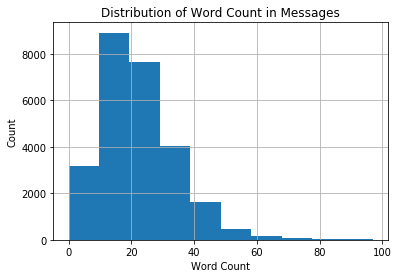

In [21]:
word_count.hist()
plt.title('Distribution of Word Count in Messages')
plt.ylabel('Count')
plt.xlabel('Word Count')

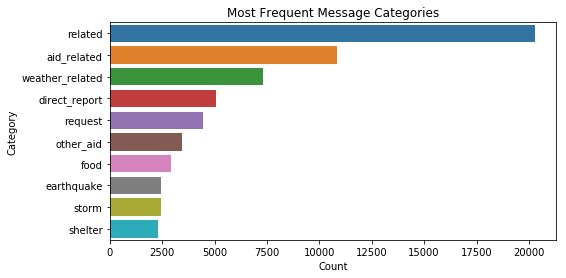

In [28]:
cat_counts = df.iloc[:, 4:].sum().sort_values(ascending=False)[:10]
cat_names = cat_counts.index.tolist()
plt.figure(figsize=(8, 4))
sns.barplot(x=cat_counts, y=cat_names)
plt.title('Most Frequent Message Categories')
plt.ylabel('Category')
plt.xlabel('Count');

In [45]:
def get_top_words(txt, num_words=10):
    tfidf = TfidfVectorizer(stop_words=stop, max_features=num_words)
    tfidf.fit(txt)
    words = tfidf.vocabulary_
    
    for word in words:
        words[word] = txt[txt.str.contains(word)].count()
    return pd.Series(words).sort_values(ascending=False)

top_counts = get_top_words(df.message)
top_words = top_counts.index.tolist()
top_counts

us            7403
water         2581
people        2468
food          2420
need          2347
help          2249
earthquake    1584
like          1541
would         1368
please        1120
dtype: int64

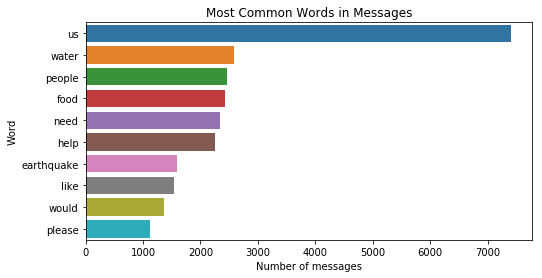

In [44]:
plt.figure(figsize=(8, 4))
sns.barplot(top_counts.values, top_counts.index)
plt.title('Most Common Words in Messages')
plt.ylabel('Word')
plt.xlabel('Number of messages');

In [20]:
word_count = df.message.apply(lambda s: len(s.split())).sort_values(ascending=False)
word_count = word_count[word_count <= 100]
word_count.head()

19862    97
21287    97
12911    97
10661    97
10678    96
Name: message, dtype: int64

Text(0.5,0,'Word Count')

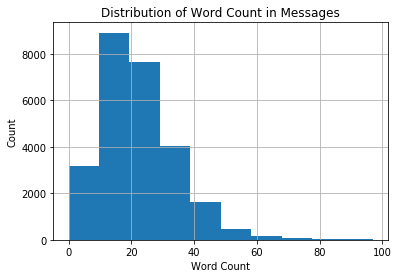

In [21]:
word_count.hist()
plt.title('Distribution of Word Count in Messages')
plt.ylabel('Count')
plt.xlabel('Word Count')